# Unsupervised Medical Image Denoising Using CycleGAN

## 1. Dataset Preparation

Loading and preprocessing medical images.Python libraries: pydicom, numpy, PIL, scikit-image, os, and glob.

Download the data from here:
https://drive.google.com/file/d/1Ov6yyzbnCC_gYNuk6RS6EfvVAoSqKGUC/view?usp=sharing

In [1]:
import os
import numpy as np
from PIL import Image
from skimage import io
from sklearn.model_selection import train_test_split
from skimage.transform import resize

# Paths to the data directories
base_dir = '/run/media/bibop/datados/CCIR_data/scrip_7/data/'

train_fd_dir = os.path.join(base_dir, 'train/fd')
train_qd_dir = os.path.join(base_dir, 'train/qd')
test_fd_dir = os.path.join(base_dir, 'test/fd')
test_qd_dir = os.path.join(base_dir, 'test/qd')

# Function to load and resize .npy files from a directory
def load_and_resize_npy_files(directory, target_shape=(256, 256), add_channels=True):
    files = sorted(os.listdir(directory))
    data = []
    for file in files:
        if file.endswith('.npy'):
            file_path = os.path.join(directory, file)
            image = np.load(file_path)
            resized_image = resize(image, target_shape, anti_aliasing=True)
            if add_channels:
                resized_image = np.expand_dims(resized_image, axis=-1)  # Add channel dimension
                resized_image = np.concatenate([resized_image] * 3, axis=-1)  # Convert to 3 channels
            data.append(resized_image)
    return np.array(data)


# Load and resize the training and testing data with the correct shape
train_fd_images = load_and_resize_npy_files(train_fd_dir, target_shape=(256, 256), add_channels=True)
train_qd_images = load_and_resize_npy_files(train_qd_dir, target_shape=(256, 256), add_channels=True)
test_fd_images = load_and_resize_npy_files(test_fd_dir, target_shape=(256, 256), add_channels=True)
test_qd_images = load_and_resize_npy_files(test_qd_dir, target_shape=(256, 256), add_channels=True)

# Print the shapes of the loaded and resized datasets
print(f'Train Full Dose Images: {train_fd_images.shape}')
print(f'Train Quarter Dose Images: {train_qd_images.shape}')
print(f'Test Full Dose Images: {test_fd_images.shape}')
print(f'Test Quarter Dose Images: {test_qd_images.shape}')

# Normalize images (optional based on the model requirements)
train_fd_images = train_fd_images / np.max(train_fd_images)
train_qd_images = train_qd_images / np.max(train_qd_images)
test_fd_images = test_fd_images / np.max(test_fd_images)
test_qd_images = test_qd_images / np.max(test_qd_images)

# If necessary, further split train data into train and validation sets
train_fd_images, val_fd_images, train_qd_images, val_qd_images = train_test_split(
    train_fd_images, train_qd_images, test_size=0.2, random_state=42
)

print(f'Validation Full Dose Images: {val_fd_images.shape}')
print(f'Validation Quarter Dose Images: {val_qd_images.shape}')



Train Full Dose Images: (3839, 256, 256, 3)
Train Quarter Dose Images: (3839, 256, 256, 3)
Test Full Dose Images: (421, 256, 256, 3)
Test Quarter Dose Images: (421, 256, 256, 3)
Validation Full Dose Images: (768, 256, 256, 3)
Validation Quarter Dose Images: (768, 256, 256, 3)


## 2. CycleGAN Model Architecture

Implementing CycleGAN using layers such as convolutional, batch normalization, and upsampling.
Python libraries: tensorflow, keras, or torch.

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

# Define the generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (7, 7), padding='same', input_shape=(256, 256, 3)))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Downsampling
    model.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Residual blocks
    for _ in range(9):
        model.add(layers.Conv2D(256, (3, 3), padding='same'))
        model.add(layers.BatchNormalization())
        model.add(layers.ReLU())

    # Upsampling
    model.add(layers.Conv2DTranspose(128, (3, 3), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    model.add(layers.Conv2DTranspose(64, (3, 3), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.ReLU())

    # Output layer
    model.add(layers.Conv2D(3, (7, 7), padding='same', activation='tanh'))

    return model

generator = build_generator()
generator.summary()


2024-08-17 14:31:29.915209: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-17 14:31:31.141786: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 64)      9472      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 64)     256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 256, 256, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     73856     
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 128)    512       
 hNormalization)                                                 
                                                                 
 re_lu_1 (ReLU)              (None, 128, 128, 128)     0

In [3]:
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (4, 4), strides=2, padding='same', input_shape=[256, 256, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(128, (4, 4), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(256, (4, 4), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(512, (4, 4), strides=2, padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Conv2D(1, (4, 4), padding='same'))  # Output single channel (real/fake)
    
    return model

discriminator = build_discriminator()
discriminator.summary()

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(disc_generated_output, gen_output, target, lambda_l1=100):
    gan_loss = loss_object(tf.ones_like(disc_generated_output), disc_generated_output)
    l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
    total_gen_loss = gan_loss + (lambda_l1 * l1_loss)
    return total_gen_loss

def discriminator_loss(real_output, fake_output):
    real_loss = loss_object(tf.ones_like(real_output), real_output)
    fake_loss = loss_object(tf.zeros_like(fake_output), fake_output)
    total_disc_loss = real_loss + fake_loss
    return total_disc_loss

generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

@tf.function
def train_step(real_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_y = generator(real_x, training=True)
        
        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(fake_y, training=True)
        
        gen_loss = generator_loss(fake_output, fake_y, real_y)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss



Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 128, 128, 64)      3136      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 128)       131200    
                                                                 
 batch_normalization_14 (Bat  (None, 64, 64, 128)      512       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 32, 32, 256)       524544    
                                                      

## 3. CycleGAN Training Loop

Training CycleGAN with the adversarial loss, cycle consistency loss, and identity loss.Python libraries: tensorflow, keras, or torch.

In [4]:
from tqdm import tqdm

# Path to save the model
model_save_dir = "/run/media/bibop/datados/CCIR_data/scrip_7/model/"
os.makedirs(model_save_dir, exist_ok=True)

batch_size = 32  # Example batch size

def train(train_qd_images, train_fd_images, val_qd_images=None, val_fd_images=None, epochs=100, save_interval=2):
    print('Start training the model')
    for epoch in range(epochs):
        # Create a tqdm progress bar for the batch processing
        progress_bar = tqdm(range(0, len(train_qd_images), batch_size), desc=f"Epoch {epoch + 1}/{epochs}")
        for i in progress_bar:
            real_x = train_qd_images[i:i+batch_size]  # Load a batch of quarter-dose images
            real_y = train_fd_images[i:i+batch_size]  # Load a batch of full-dose images
            
            # Perform a training step
            gen_loss, disc_loss = train_step(real_x, real_y)
            
            # Update the progress bar with the current loss values
            progress_bar.set_postfix({
                "Generator Loss": f"{gen_loss.numpy():.4f}", 
                "Discriminator Loss": f"{disc_loss.numpy():.4f}"
            })

        print(f'Epoch {epoch + 1}/{epochs}: Generator Loss: {gen_loss.numpy()}, Discriminator Loss: {disc_loss.numpy()}')
        
        # Optional: Evaluate on validation set
        if val_qd_images is not None and val_fd_images is not None:
            val_loss = 0
            for j in range(0, len(val_qd_images), batch_size):
                val_x = val_qd_images[j:j+batch_size]
                val_y = val_fd_images[j:j+batch_size]
                fake_y = generator(val_x, training=False)
                disc_fake_y = discriminator(fake_y, training=False)
                val_loss += generator_loss(disc_fake_y, fake_y, val_y)
            print(f'Validation Loss after Epoch {epoch + 1}: {val_loss.numpy() / len(val_qd_images)}')
        
        # Save the model at specified intervals
        if (epoch + 1) % save_interval == 0:
            generator.save(os.path.join(model_save_dir, f"generator_epoch_{epoch + 1}.h5"))
            discriminator.save(os.path.join(model_save_dir, f"discriminator_epoch_{epoch + 1}.h5"))
            print(f"Model saved after Epoch {epoch + 1}")




In [5]:
# Example usage
train(train_qd_images, train_fd_images, val_qd_images, val_fd_images, epochs=10)

Start training the model


Epoch 1/10: 100%|██████████████████| 96/96 [47:05<00:00, 29.43s/it, Generator Loss=5.7206, Discriminator Loss=0.1030]


Epoch 1/10: Generator Loss: 5.720572471618652, Discriminator Loss: 0.10297544300556183
Validation Loss after Epoch 1: 0.15421897172927856


Epoch 2/10: 100%|██████████████████| 96/96 [47:13<00:00, 29.52s/it, Generator Loss=8.9831, Discriminator Loss=0.0091]


Epoch 2/10: Generator Loss: 8.983121871948242, Discriminator Loss: 0.009118368849158287
Validation Loss after Epoch 2: 0.21712191899617514
Model saved after Epoch 2


Epoch 3/10: 100%|██████████████████| 96/96 [47:09<00:00, 29.48s/it, Generator Loss=9.5008, Discriminator Loss=0.0056]


Epoch 3/10: Generator Loss: 9.50082015991211, Discriminator Loss: 0.005565186962485313
Validation Loss after Epoch 3: 0.18410342931747437


Epoch 4/10: 100%|██████████████████| 96/96 [46:58<00:00, 29.36s/it, Generator Loss=3.2878, Discriminator Loss=0.2615]


Epoch 4/10: Generator Loss: 3.2877511978149414, Discriminator Loss: 0.26146915555000305
Validation Loss after Epoch 4: 0.08598353465398152
Model saved after Epoch 4


Epoch 5/10: 100%|██████████████████| 96/96 [46:42<00:00, 29.19s/it, Generator Loss=7.5954, Discriminator Loss=0.0332]


Epoch 5/10: Generator Loss: 7.595400810241699, Discriminator Loss: 0.033158063888549805
Validation Loss after Epoch 5: 0.19683416684468588


Epoch 6/10: 100%|██████████████████| 96/96 [46:50<00:00, 29.27s/it, Generator Loss=8.2000, Discriminator Loss=0.0044]


Epoch 6/10: Generator Loss: 8.200003623962402, Discriminator Loss: 0.004423040896654129
Validation Loss after Epoch 6: 0.12433198094367981
Model saved after Epoch 6


Epoch 7/10: 100%|██████████████████| 96/96 [46:45<00:00, 29.23s/it, Generator Loss=8.2951, Discriminator Loss=0.0033]


Epoch 7/10: Generator Loss: 8.295080184936523, Discriminator Loss: 0.0033195209689438343
Validation Loss after Epoch 7: 0.7938363552093506


Epoch 8/10: 100%|██████████████████| 96/96 [46:38<00:00, 29.15s/it, Generator Loss=8.5272, Discriminator Loss=0.0027]


Epoch 8/10: Generator Loss: 8.527246475219727, Discriminator Loss: 0.0027161308098584414
Validation Loss after Epoch 8: 0.13473608096440634
Model saved after Epoch 8


Epoch 9/10: 100%|██████████████████| 96/96 [46:35<00:00, 29.12s/it, Generator Loss=7.1001, Discriminator Loss=0.0118]


Epoch 9/10: Generator Loss: 7.1000895500183105, Discriminator Loss: 0.011763520538806915
Validation Loss after Epoch 9: 0.08072467645009358


Epoch 10/10: 100%|█████████████████| 96/96 [46:42<00:00, 29.20s/it, Generator Loss=8.7037, Discriminator Loss=0.0021]


Epoch 10/10: Generator Loss: 8.703703880310059, Discriminator Loss: 0.002074228832498193
Validation Loss after Epoch 10: 0.10063684980074565
Model saved after Epoch 10


## 4. Load the Saved Model

You can load the saved generator model using tf.keras.models.load_model. This will allow you to use the model for generating predictions on the test set.

In [11]:
import tensorflow as tf
import matplotlib.pyplot as plt

# Load the saved generator model
generator = tf.keras.models.load_model("/run/media/bibop/datados/CCIR_data/scrip_7/model/generator_epoch_10.h5")


## 5. Generate Predictions on the Test Set

Use the loaded generator to generate predictions (denoised images) on the test set.

In [12]:
# Generate predictions on the test set
def generate_predictions(generator, test_qd_images):
    predictions = generator.predict(test_qd_images)
    return predictions

# Example: Generate predictions for the test set
predicted_images = generate_predictions(generator, test_qd_images)


14/14 [==============================] - 129s 9s/step


## 7. Visualize the Results

You can use matplotlib to visualize the original (noisy) test images alongside the predicted (denoised) images and the ground truth (full-dose) images.

In [13]:
def visualize_results(test_qd_images, test_fd_images, predicted_images, num_images=5):
    plt.figure(figsize=(15, 15))
    for i in range(num_images):
        # Display the noisy image (quarter-dose)
        plt.subplot(num_images, 3, i*3 + 1)
        plt.imshow(test_qd_images[i].squeeze(), cmap='gray')
        plt.title("Noisy Image")
        plt.axis('off')

        # Display the predicted image (denoised)
        plt.subplot(num_images, 3, i*3 + 2)
        plt.imshow(predicted_images[i].squeeze(), cmap='gray')
        plt.title("Denoised Image")
        plt.axis('off')

        # Display the ground truth image (full-dose)
        plt.subplot(num_images, 3, i*3 + 3)
        plt.imshow(test_fd_images[i].squeeze(), cmap='gray')
        plt.title("Ground Truth")
        plt.axis('off')

    plt.show()

# Example: Visualize the results


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

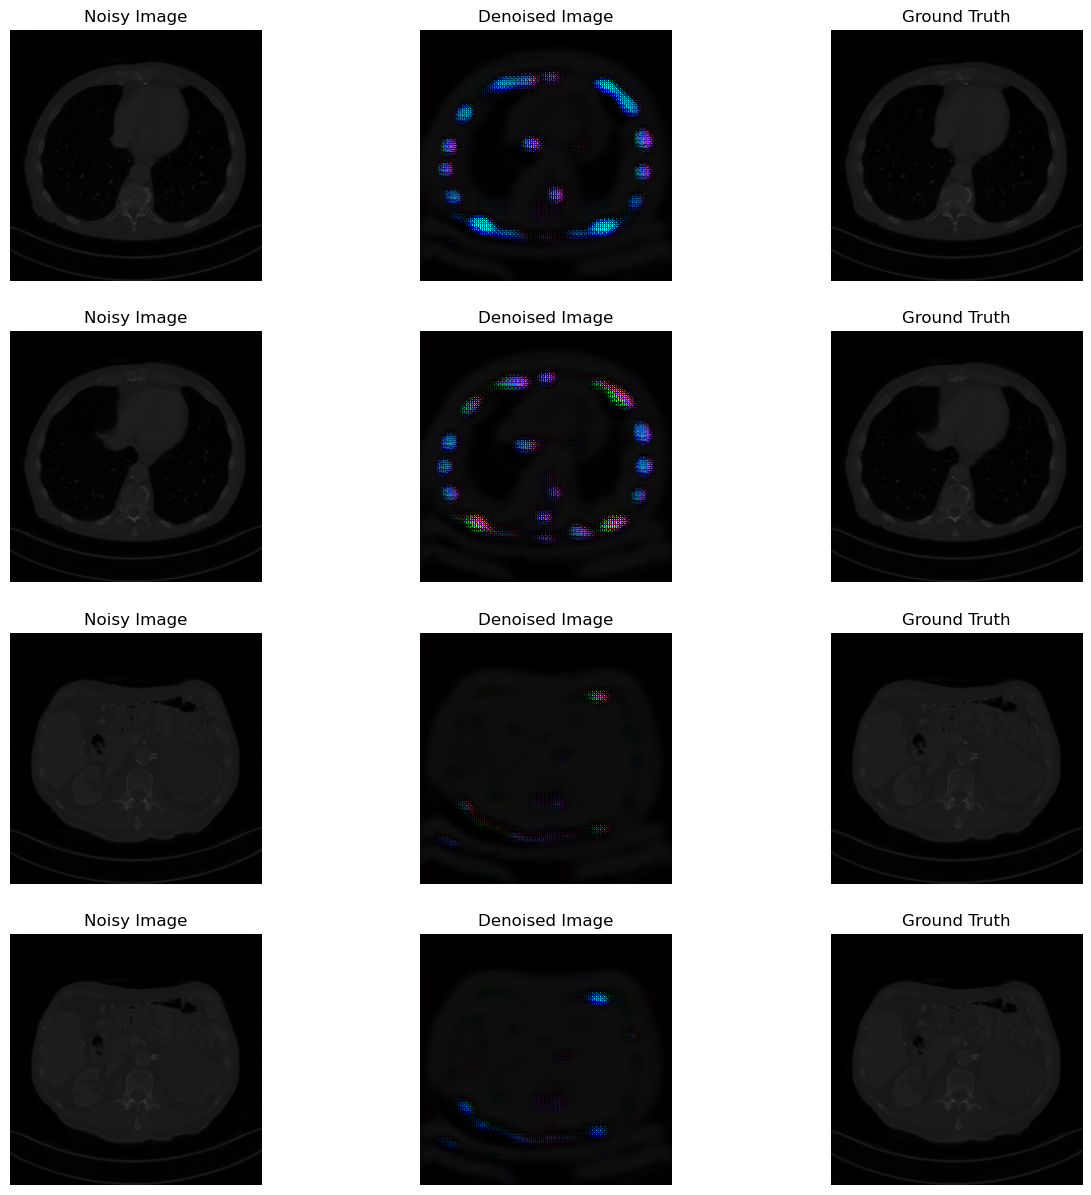

In [14]:
visualize_results(test_qd_images, test_fd_images, predicted_images, num_images=4)

## 8. Metrics

If you want to quantitatively evaluate the model's performance, you can calculate metrics such as PSNR (Peak Signal-to-Noise Ratio) or SSIM (Structural Similarity Index) between the predicted images and the ground truth images.

In [15]:
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

def evaluate_metrics(test_fd_images, predicted_images):
    psnr_scores = []
    ssim_scores = []
    for i in range(len(test_fd_images)):
        psnr = peak_signal_noise_ratio(test_fd_images[i], predicted_images[i])
        ssim = structural_similarity(test_fd_images[i].squeeze(), predicted_images[i].squeeze(), multichannel=True)
        psnr_scores.append(psnr)
        ssim_scores.append(ssim)
    return np.mean(psnr_scores), np.mean(ssim_scores)

# Example: Calculate metrics
average_psnr, average_ssim = evaluate_metrics(test_fd_images, predicted_images)
print(f"Average PSNR: {average_psnr}")
print(f"Average SSIM: {average_ssim}")


ValueError: win_size exceeds image extent. Either ensure that your images are at least 7x7; or pass win_size explicitly in the function call, with an odd value less than or equal to the smaller side of your images. If your images are multichannel (with color channels), set channel_axis to the axis number corresponding to the channels.